# Idea
The idea is that we predict rotated linear dimension position from lines and text from the drawing.

# Thoughts
Basic logic is we split dataset to input lines or texts positions StartPoint, EndPoint, Position XYZ and predict dimension extension line poistion XLine1Point, XLine2Point XYZ.

We going to group samples by FileId. That is each sample will contain variable length data (attributes of variable number of  lines and text) and variable output data (variable number of dimensions).

I intend to [use RNN for it](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
# https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
import torch
from torch import nn
from torch.utils.data import Dataset, SubsetRandomSampler
from torch.nn import functional as F


device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    
device

device(type='cuda')

# Dataset implementation

In [3]:
from dataset import DwgDataset
batch_size = 1

dwg_dataset = DwgDataset(pickle_file = 'test_dataset.pickle', batch_size = batch_size)

train_loader = dwg_dataset.train_loader
val_loader   = dwg_dataset.val_loader
test_loader  = dwg_dataset.test_loader

ent_features = dwg_dataset.entities.ent_features
dim_features = dwg_dataset.entities.dim_features

In [4]:
for c,d in dwg_dataset.entities:
    # print(c.shape, d.shape)
    # make sure we have every training sample not empty
    assert( c.shape[0] != 0)    

In [5]:
(a,b) = next(iter(train_loader))
print(len(a),len(b))
for (x,y) in iter(train_loader):
    for xx in x:
        print(xx.shape)
        pass
    for yy in y:
        print(yy.shape)
    # print(a.shape,b.shape)
    break

1 1
torch.Size([1617, 9])
torch.Size([0, 6])


# Model and training


In [6]:
from model import RnnDecoder, RnnEncoder
rnn_encoder = RnnEncoder(ent_features, 1024, enforced_device = device).to(device)
rnn_decoder = RnnDecoder(1024, dim_features, enforced_device = device).to(device)

In [7]:
(x,y) = next(iter(train_loader))
print('inputs','x:',len(x),'x',x[0].shape,'y:',len(y),'x',y[0].shape)
outs_numbers, learned = rnn_encoder(x)
print('learned shape:', learned.shape)
print("outs shape:", outs_numbers.shape, 'outs_value', outs_numbers)
# make sure something is passed
outs_numbers[0] = 42
decoded = rnn_decoder(outs_numbers, learned)
print('decoded:',len(decoded),'x', decoded[0].shape)

inputs x: 1 x torch.Size([172, 9]) y: 1 x torch.Size([55, 6])
learned shape: torch.Size([1, 1024])
outs shape: torch.Size([1, 1]) outs_value tensor([[0.]], device='cuda:0', grad_fn=<CopySlices>)
decoded: 1 x torch.Size([42, 6])


In [8]:
%matplotlib inline
from train import train_model, plot_history

[0-0 @ 0.4 sec] Log10 Loss: 2.790644 Train err: 89.2%
[0-1 @ 0.5 sec] Log10 Loss: 1.313294 Train err: 100.0%
[0-2 @ 0.7 sec] Log10 Loss: 2.187478 Train err: 94.9%
[0-3 @ 0.8 sec] Log10 Loss: 3.240792 Train err: 85.0%
[0-4 @ 0.8 sec] Log10 Loss: 1.621026 Train err: 100.0%
[0-5 @ 0.9 sec] Log10 Loss: 1.323988 Train err: 100.0%
[0-6 @ 0.9 sec] Log10 Loss: 1.614212 Train err: 97.7%
[0-7 @ 1.0 sec] Log10 Loss: 1.463251 Train err: 100.0%
[0-8 @ 1.0 sec] Log10 Loss: 2.319319 Train err: 82.0%
[0-9 @ 1.1 sec] Log10 Loss: 1.155379 Train err: 0.0%
[0-10 @ 1.2 sec] Log10 Loss: 1.476206 Train err: 100.0%
[0-11 @ 3.2 sec] Log10 Loss: 3.400877 Train err: 90.3%
[0-12 @ 3.2 sec] Log10 Loss: 2.665187 Train err: 92.6%
[0-13 @ 3.3 sec] Log10 Loss: 1.785856 Train err: 95.6%
[0-14 @ 3.5 sec] Log10 Loss: 1.514662 Train err: 100.0%
[0-15 @ 3.6 sec] Log10 Loss: 1.820800 Train err: 91.5%
[0-16 @ 3.6 sec] Log10 Loss: 1.435421 Train err: 100.0%
[0-17 @ 4.0 sec] Log10 Loss: 1.842803 Train err: 85.6%
[0-18 @ 4.2 se

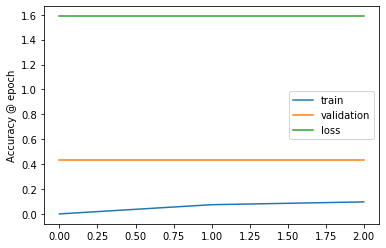

In [9]:
lr = 3e-4
epochs = 3
decoder_optimizer = torch.optim.Adam(rnn_decoder.parameters(), lr = lr)
encoder_optimizer = torch.optim.Adam(rnn_encoder.parameters(), lr = lr)
from chamfer_distance_loss import MyChamferDistance
loss = MyChamferDistance()

loss_history, train_history, val_history = train_model(
    encoder = rnn_encoder, 
    decoder = rnn_decoder, 
    train_loader = train_loader,
    val_loader = val_loader,
    loss = loss,
    decoder_opt = decoder_optimizer,
    encoder_opt = encoder_optimizer,
    epochs = epochs)

plot_history(loss_history, train_history, val_history)

In [10]:
# https://blog.paperspace.com/pytorch-memory-multi-gpu-debugging/
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 61% | 70% |


In [11]:
from train import calculate_accuracy
i = 0
for (x, y) in iter(val_loader):
    outs, learned = rnn_encoder(x)
    decoded = rnn_decoder(outs, learned)
    
    yyy = []
    for yy in y:
        yyy.append(yy.shape[0])
    ppp = []
    for dd in decoded:
        ppp.append(dd.shape[0])
    
    print('actual:', yyy)
    print('predicted:', ppp)
    
    lv = loss(decoded, y)
    print ('loss:', lv)

    acc = calculate_accuracy(decoded, y)
    print('accuracy:', acc)

    i += 1
    print(i, '------------------------------')

actual: [0]
predicted: [1]
loss: tensor([1.0033], grad_fn=<AddBackward0>)
accuracy: [1]
1 ------------------------------
actual: [0]
predicted: [1]
loss: tensor([1.2233], grad_fn=<AddBackward0>)
accuracy: [1]
2 ------------------------------
actual: [0]
predicted: [2]
loss: tensor([1.1961], grad_fn=<AddBackward0>)
accuracy: [0]
3 ------------------------------
actual: [100]
predicted: [0]
loss: tensor([1.1707], grad_fn=<AddBackward0>)
accuracy: [0]
4 ------------------------------
actual: [3]
predicted: [1109]
loss: tensor([2.6501], grad_fn=<AddBackward0>)
accuracy: [0.14638662338256836]
5 ------------------------------


In [12]:
ii = pd.DataFrame(x[0].cpu().detach().numpy())
print(ii.head())
yy = pd.DataFrame(y[0].cpu().detach().numpy())
print(len(yy))
print(yy.head())
pp = pd.DataFrame(decoded[0].cpu().detach().numpy())
print(len(pp))
print(pp.head())

     0    1    2    3    4    5         6         7    8
0  0.0  0.0  1.0  0.0  0.0  1.0  0.704550  0.993571  0.0
1  0.0  0.0  1.0  0.0  0.0  1.0  0.032872  0.076172  0.0
2  0.0  0.0  1.0  0.0  0.0  1.0  0.034243  0.032112  0.0
3  0.0  0.0  1.0  0.0  0.0  1.0  0.034243  0.024829  0.0
4  0.0  0.0  1.0  0.0  0.0  1.0  0.034243  0.053349  0.0
3
          0    1         2         3         4         5
0  0.000000  0.0  0.363057  0.000000  0.000000  0.000000
1  0.081114  0.0  0.000000  0.081783  1.000000  0.333333
2  1.000000  1.0  1.000000  1.000000  0.781558  1.000000
1109
          0         1         2         3         4         5
0 -0.735503  0.242185 -0.010942  0.495159  0.349049  0.107618
1 -0.722262  0.200295  0.014158  0.654436  0.261402 -0.082537
2 -0.721498  0.239717  0.046352  0.683690  0.170664 -0.128214
3 -0.734776  0.218683  0.037967  0.686598  0.173362 -0.139842
4 -0.731162  0.227371  0.053353  0.692466  0.160976 -0.144932


In [13]:
from train import calculate_accuracy
torch.cuda.empty_cache()

rnn_encoder.eval()
rnn_decoder.eval()

test_accuracies = []
for (x,y) in test_loader:
    with torch.no_grad():
        out, hidden = rnn_encoder(x)
        prediction = rnn_decoder(out, hidden)
        accuracy = calculate_accuracy(prediction, y)
        test_accuracies.append(accuracy)
        
mean_test_accuracy = np.mean(test_accuracies)
print('Accuracy on testing: {0:2.3f}'.format(mean_test_accuracy))

Accuracy on testing: 0.041
